# Summarizing Research Outputs - Base dataset

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import time

# import the parquet library
import pyarrow.parquet as pq

# import model libraries
from sklearn.metrics import mean_squared_error, accuracy_score, mean_absolute_error

import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
# load the data base_portfolio_reg1.parquet and base_lvwreturns_reg1.parquet

# portfolios
# regressions
portfolio1 = pd.read_parquet('market_portfolio_reg1.parquet') # all regressions
portfolio2 = pd.read_parquet('market_portfolio_class1.parquet') # classification - no Lasso
portfolio3 = pd.read_parquet('market_portfolio_class2.parquet') # classification - Lasso

portfolio4 = pd.read_parquet('market_portfolio_reg1_MSE.parquet')
portfolio5 = pd.read_parquet('market_portfolio_class1_MSE.parquet')
portfolio6 = pd.read_parquet('market_portfolio_class2_MSE.parquet')


## Prediction Evaluation (MAE, MSE, Accuracy) and Comparison of ML Algorithms

### Decile accuracy

In [3]:
# Assuming original portfolio DataFrames are named as such
dataframes = {
    'portfolio1': portfolio1,
    'portfolio2': portfolio2,
    'portfolio3': portfolio3, 
    'portfolio4': portfolio4,
    'portfolio5': portfolio5,
    'portfolio6': portfolio6 
}

# Loop through the dictionary to drop columns
for name, df in dataframes.items():
    # Find columns that start with "position" or "decile"
    columns_to_drop = [col for col in df.columns if col.startswith('decile')]
    # Drop these columns
    df.drop(columns=columns_to_drop, inplace=True)
    # Update the dictionary with the modified DataFrame
    dataframes[name] = df

# Columns to be dropped
columns_to_drop = ['date', 'RET', 'ME']


# Loop through the dictionary, skipping the first item
for name, df in list(dataframes.items()):  # [1:] skips the first item
    # Check if DataFrame contains the columns to be dropped
    cols_to_drop = [col for col in columns_to_drop if col in df.columns]
    # Drop the columns if present
    if cols_to_drop:
        df.drop(columns=cols_to_drop, inplace=True)


# keep only predictions for the top and bottom deciles
for portfolio_name, df in dataframes.items():
    for col in df.columns:
        # If column does not start with "position_", check for a corresponding "position_" column
        if not col.startswith("position_"):
            position_col = f"position_{col}"
            if position_col in df.columns:
                # Replace model's value with NaN where position is 0
                df.loc[df[position_col] == 0, col] = np.nan
    # Drop columns starting with "position"
    df.drop(columns=[col for col in df.columns if col.startswith("position_")], inplace=True)
    
    # Update the dictionary with the modified dataframe
    dataframes[portfolio_name] = df



# Now, dataframes['portfolio1'], dataframes['portfolio2'], and dataframes['portfolio3'] have the columns dropped
# If you need to work directly with the modified portfolio1, portfolio2, and portfolio3, you can extract them like so:
portfolio1, portfolio2, portfolio3, portfolio4, portfolio5, portfolio6 = dataframes.values()

In [4]:
metrics_decile = pd.DataFrame(columns=['Accuracy', 'MAE', 'MSE'])

def calculate_accuracy(y_true, y_pred):
    # Exclude NaN values from both y_true and y_pred
    valid_indices = ~y_pred.isna()
    y_true_valid = y_true[valid_indices]
    y_pred_valid = y_pred[valid_indices]
    y_pred_class = (y_pred_valid >= 0.5).astype(int)
    accuracy = np.mean(y_true_valid == y_pred_class)
    return accuracy

# Loop over each portfolio DataFrame
for name, portfolio in dataframes.items():
    y = portfolio['y']
    for column in portfolio.columns:
        if column == 'y':
            continue  # Skip the 'y' column

        # Calculate metrics, excluding NaN values
        valid_indices = ~portfolio[column].isna()
        if valid_indices.sum() > 0:  # Proceed only if there are non-NaN predictions
            accuracy = calculate_accuracy(y[valid_indices], portfolio[column][valid_indices])
            mae = mean_absolute_error(y[valid_indices], portfolio[column][valid_indices])
            mse = mean_squared_error(y[valid_indices], portfolio[column][valid_indices])

            # Store metrics in the DataFrame
            metrics_decile.loc[column] = [accuracy, mae, mse]
        else:
            # Handle the case where all predictions are NaN
            metrics_decile.loc[column] = [np.nan, np.nan, np.nan]

# Display the DataFrame with the calculated metrics
metrics_decile.head(20)

,Accuracy,MAE,MSE
ols_default,0.978147,0.213724,0.105328
ridge_reg_roll5,0.979427,0.207129,0.086630
lasso_reg_roll5,0.943772,0.342307,0.128522
DT_reg_roll5,0.970934,0.043393,0.021118
RF_reg_roll5,0.972222,0.039652,0.019412
base_ols_default,0.977301,0.214349,0.087849
ridge_clas_roll5,0.990338,0.014096,0.007000
DT_class_roll5,0.947678,0.087007,0.042933
RF_class_roll5,0.998134,0.018760,0.002126
lasso_clas_roll5,0.990587,0.015380,0.007514


In [5]:
# display only rows where index = 'ridge_reg_roll5','ridge_clas_roll5_AC', 'ridge_clas_roll5_decAC', 'RF_class_roll5_AC', 'RF_reg_exp', 'ols_default'
print_metrics = ['RF_reg_roll5_MSE', 'RF_class_roll5',  'DT_class_roll5_MSE', 'base_ols_default', 'lasso_clas_roll5']

metrics_decile[['Accuracy', 'MSE']].loc[print_metrics].sort_values(by='Accuracy', ascending=False).head(10)


,Accuracy,MSE
RF_class_roll5,0.998134,0.002126
lasso_clas_roll5,0.990587,0.007514
RF_reg_roll5_MSE,0.980061,0.013342
base_ols_default,0.977301,0.087849
DT_class_roll5_MSE,0.975667,0.017310


In [6]:
# Iterate over the row labels (index) of the metrics_decile DataFrame
for label in metrics_decile.index:
    # Determine 'type'
    if "reg" in label:
        metrics_decile.loc[label, 'type'] = 'reg'
    elif "clas" in label:
        metrics_decile.loc[label, 'type'] = 'class'
    elif "ols" in label:
        metrics_decile.loc[label, 'type'] = 'reg'
    else:
        metrics_decile.loc[label, 'type'] = 'class'

    
    # Determine 'metric'
    if label.endswith("MSE"):
        metrics_decile.loc[label, 'metric'] = 'mse'
    else:
        metrics_decile.loc[label, 'metric'] = 'acc'

    # Determine 'Algorithm'
    if "ridge" in label:
        metrics_decile.loc[label, 'algorithm'] = 'ridge'
    elif "DT" in label:
        metrics_decile.loc[label, 'algorithm'] = 'DT'
    elif "RF" in label:
        metrics_decile.loc[label, 'algorithm'] = 'RF'
    else:
        metrics_decile.loc[label, 'algorithm'] = 'other'


In [7]:
metrics_decile.sort_values(by='Accuracy', ascending=False, inplace=True)
metrics_decile.head(30)

,Accuracy,MAE,MSE,type,metric,algorithm
RF_class_roll5_MSE,0.998433,0.010001,0.001393,class,mse,RF
RF_class_roll5,0.998134,0.018760,0.002126,class,acc,RF
ridge_clas_roll5_MSE,0.992289,0.010018,0.006373,class,mse,ridge
lasso_clas_roll5_MSE,0.991753,0.010245,0.006996,class,mse,other
lasso_clas_roll5,0.990587,0.015380,0.007514,class,acc,other
ridge_clas_roll5,0.990338,0.014096,0.007000,class,acc,ridge
RF_reg_roll5_MSE,0.980061,0.026835,0.013342,reg,mse,RF
ridge_reg_roll5,0.979427,0.207129,0.086630,reg,acc,ridge
ols_default,0.978147,0.213724,0.105328,reg,acc,other
ridge_reg_roll5_MSE,0.977651,0.215266,0.099218,reg,mse,ridge


In [8]:
# First, generate dummy variables for categorical predictors
X = pd.get_dummies(metrics_decile[['type', 'metric', 'algorithm']], drop_first=True)
# Add a constant to the model (intercept)
X = sm.add_constant(X)

# Model 1: Accuracy as the dependent variable
y_accuracy = metrics_decile['Accuracy']
model_accuracy = sm.OLS(y_accuracy, X).fit()

# Model 2: MSE as the dependent variable
y_mse = metrics_decile['MSE']
model_mse = sm.OLS(y_mse, X).fit()

# Print the summary tables of both regressions
print("OLS Regression Model Summary (Dependent Variable: Accuracy)")
print(model_accuracy.summary())
print("\nOLS Regression Model Summary (Dependent Variable: MSE)")
print(model_mse.summary())

OLS Regression Model Summary (Dependent Variable: Accuracy)
                            OLS Regression Results                            
Dep. Variable:               Accuracy   R-squared:                       0.426
Model:                            OLS   Adj. R-squared:                  0.187
Method:                 Least Squares   F-statistic:                     1.781
Date:                Wed, 06 Mar 2024   Prob (F-statistic):              0.191
Time:                        13:06:34   Log-Likelihood:                 51.748
No. Observations:                  18   AIC:                            -91.50
Df Residuals:                      12   BIC:                            -86.15
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------

c:\Users\tomta\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
c:\Users\tomta\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [9]:
# print average accuracy grouped by type and method
print(metrics_decile.groupby(['type', 'metric'])['Accuracy'].mean())

type   metric
class  acc       0.981685
       mse       0.989536
reg    acc       0.970300
       mse       0.966159
Name: Accuracy, dtype: float64


In [57]:
print(metrics_decile['Accuracy'].mean())

0.9761843695871697


### Overall Accuracy

Drop useless columns from portfolio dataframes.

In [10]:
# load the data base_portfolio_reg1.parquet and base_lvwreturns_reg1.parquet

# portfolios
# regressions
portfolio1 = pd.read_parquet('market_portfolio_reg1.parquet') # all regressions
portfolio2 = pd.read_parquet('market_portfolio_class1.parquet') # classification - no Lasso
portfolio3 = pd.read_parquet('market_portfolio_class2.parquet') # classification - Lasso

portfolio4 = pd.read_parquet('market_portfolio_reg1_MSE.parquet')
portfolio5 = pd.read_parquet('market_portfolio_class1_MSE.parquet')
portfolio6 = pd.read_parquet('market_portfolio_class2_MSE.parquet')

In [11]:
# Assuming your DataFrames are already defined as portfolio1, portfolio2, and portfolio3
# Create a dictionary mapping names to DataFrame objects
dataframes = {
    'portfolio1': portfolio1,
    'portfolio2': portfolio2,
    'portfolio3': portfolio3, 
    'portfolio4': portfolio4,
    'portfolio5': portfolio5,
    'portfolio6': portfolio6
}

# Loop through the dictionary to drop columns
for name, df in dataframes.items():
    # Find columns that start with "position" or "decile"
    columns_to_drop = [col for col in df.columns if col.startswith('position') or col.startswith('decile')]
    # Drop these columns
    df.drop(columns=columns_to_drop, inplace=True)
    # Update the dictionary with the modified DataFrame
    dataframes[name] = df

# Columns to be dropped
columns_to_drop = ['date', 'RET', 'ME']


# Loop through the dictionary, skipping the first item
for name, df in list(dataframes.items()):  # [1:] skips the first item
    # Check if DataFrame contains the columns to be dropped
    cols_to_drop = [col for col in columns_to_drop if col in df.columns]
    # Drop the columns if present
    if cols_to_drop:
        df.drop(columns=cols_to_drop, inplace=True)


# Now, dataframes['portfolio1'], dataframes['portfolio2'], and dataframes['portfolio3'] have the columns dropped
# If you need to work directly with the modified portfolio1, portfolio2, and portfolio3, you can extract them like so:
portfolio1, portfolio2, portfolio3, portfolio4, portfolio5, portfolio6 = dataframes.values()


In [12]:
# Initialize a DataFrame to store the metrics
metrics_df = pd.DataFrame(columns=['Accuracy', 'MAE', 'MSE'])

# Function to calculate accuracy assuming binary classification with threshold 0.5
def calculate_accuracy(y_true, y_pred):
    y_pred_class = (y_pred >= 0.5).astype(int)
    accuracy = np.mean(y_true == y_pred_class)
    return accuracy

# Loop over each portfolio DataFrame
for name, portfolio in dataframes.items():
    for column in portfolio.columns:
        if column == 'y' or column in metrics_df.index:
            continue  # Skip the 'y' column and any column already processed

        # Calculate metrics
        accuracy = calculate_accuracy(portfolio['y'], portfolio[column])
        mae = mean_absolute_error(portfolio['y'], portfolio[column])
        mse = mean_squared_error(portfolio['y'], portfolio[column])

        # Store metrics in the DataFrame
        metrics_df.loc[column] = [accuracy, mae, mse]

# Display the DataFrame with the calculated metrics
metrics_df.head()


,Accuracy,MAE,MSE
ols_default,0.866633,0.333716,0.142686
ridge_reg_roll5,0.830198,0.342816,0.149127
lasso_reg_roll5,0.779208,0.425319,0.191502
DT_reg_roll5,0.969496,0.048708,0.024000
RF_reg_roll5,0.969437,0.048815,0.023846


In [13]:
metrics_df[['Accuracy', 'MSE']].loc[print_metrics].sort_values(by='Accuracy', ascending=False).head(10)

,Accuracy,MSE
RF_class_roll5,0.970231,0.027782
RF_reg_roll5_MSE,0.970170,0.022621
DT_class_roll5_MSE,0.969657,0.023492
lasso_clas_roll5,0.922842,0.057258
base_ols_default,0.827494,0.151445


In [14]:
# Iterate over the row labels (index) of the DataFrame
for label in metrics_df.index:
    # Determine 'algorithm'
    if "reg" in label:
        metrics_df.loc[label, 'type'] = 'reg'
    elif "clas" in label:
        metrics_df.loc[label, 'type'] = 'class'
    elif "ols" in label:
        metrics_df.loc[label, 'type'] = 'reg'
    else:
        metrics_df.loc[label, 'type'] = 'class'
    
    
    # Determine 'metric'
    if label.endswith("MSE"):
        metrics_df.loc[label, 'metric'] = 'mse'
    else:
        metrics_df.loc[label, 'metric'] = 'acc'

    # Determine 'Algorithm'
    if "ridge" in label:
        metrics_df.loc[label, 'algorithm'] = 'ridge'
    elif "DT" in label:
        metrics_df.loc[label, 'algorithm'] = 'DT'
    elif "RF" in label:
        metrics_df.loc[label, 'algorithm'] = 'RF'
    else:
        metrics_df.loc[label, 'algorithm'] = 'other'


In [15]:
# sort the dataframe by MSE

metrics_df.sort_values(by='Accuracy', ascending=False, inplace=True)

metrics_df.head(30)

,Accuracy,MAE,MSE,type,metric,algorithm
RF_class_roll5_MSE,0.970411,0.073959,0.024782,class,mse,RF
RF_class_roll5,0.970231,0.092549,0.027782,class,acc,RF
RF_reg_roll5_MSE,0.970170,0.047029,0.022621,reg,mse,RF
DT_class_roll5_MSE,0.969657,0.047069,0.023492,class,mse,DT
DT_reg_roll5_MSE,0.969653,0.047029,0.023479,reg,mse,DT
DT_reg_roll5,0.969496,0.048708,0.024000,reg,acc,DT
RF_reg_roll5,0.969437,0.048815,0.023846,reg,acc,RF
DT_class_roll5,0.960822,0.065869,0.032372,class,acc,DT
lasso_clas_roll5_MSE,0.947580,0.091500,0.041514,class,mse,other
ridge_clas_roll5_MSE,0.938312,0.108713,0.048049,class,mse,ridge


In [16]:
# First, generate dummy variables for categorical predictors
X = pd.get_dummies(metrics_df[['type', 'metric', 'algorithm']], drop_first=True)
# Add a constant to the model (intercept)
X = sm.add_constant(X)

# Model 1: Accuracy as the dependent variable
y_accuracy = metrics_df['Accuracy']
model_tot_accuracy = sm.OLS(y_accuracy, X).fit()

# Model 2: MSE as the dependent variable
y_mse = metrics_df['MSE']
model_tot_mse = sm.OLS(y_mse, X).fit()

# Print the summary tables of both regressions
print("OLS Regression Model Summary (Dependent Variable: Accuracy)")
print(model_tot_accuracy.summary())


OLS Regression Model Summary (Dependent Variable: Accuracy)
                            OLS Regression Results                            
Dep. Variable:               Accuracy   R-squared:                       0.767
Model:                            OLS   Adj. R-squared:                  0.670
Method:                 Least Squares   F-statistic:                     7.912
Date:                Wed, 06 Mar 2024   Prob (F-statistic):            0.00167
Time:                        13:06:40   Log-Likelihood:                 35.835
No. Observations:                  18   AIC:                            -59.67
Df Residuals:                      12   BIC:                            -54.33
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------

c:\Users\tomta\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [17]:
print("\nOLS Regression Model Summary (Dependent Variable: MSE)")
print(model_tot_mse.summary())


OLS Regression Model Summary (Dependent Variable: MSE)
                            OLS Regression Results                            
Dep. Variable:                    MSE   R-squared:                       0.774
Model:                            OLS   Adj. R-squared:                  0.680
Method:                 Least Squares   F-statistic:                     8.209
Date:                Wed, 06 Mar 2024   Prob (F-statistic):            0.00142
Time:                        13:06:40   Log-Likelihood:                 37.730
No. Observations:                  18   AIC:                            -63.46
Df Residuals:                      12   BIC:                            -58.12
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------

c:\Users\tomta\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [56]:
print(metrics_df.groupby(['type', 'metric'])['Accuracy'].mean())

type   metric
class  acc       0.937147
       mse       0.956490
reg    acc       0.873744
       mse       0.889730
Name: Accuracy, dtype: float64


In [ ]:
# print the average accuracy


## Portfolio Comparison in terms of returns

In [18]:
# returns
returns1 = pd.read_parquet('market_lvwreturns_reg1.parquet') # regression
returns2 = pd.read_parquet('market_lvwreturns_class1.parquet')  # no Lasso
returns3 = pd.read_parquet('market_lvwreturns_class2.parquet') # Lasso

returns4 = pd.read_parquet('market_lvwreturns_reg1_MSE.parquet')
returns5 = pd.read_parquet('market_lvwreturns_class1_MSE.parquet')
returns6 = pd.read_parquet('market_lvwreturns_class2_MSE.parquet')


### Handling the files

In [19]:
# drop the Mkt column from returns except for returns1

n_files = 6

# for "returns{i]" drop the Mkt column
for i in range(2, n_files + 1):
    returns = globals()[f'returns{i}']
    returns = returns.drop('Mkt', axis=1)
    globals()[f'returns{i}'] = returns

In [20]:
from functools import reduce

# Assuming your DataFrames are already loaded as returns1, returns2, ..., returns11
dataframes = [returns1, returns2, returns3, returns4, returns5, returns6]

# Use functools.reduce to merge all DataFrames on 'date'
log_ret = reduce(lambda left, right: pd.merge(left, right, on='date', how='inner'), dataframes)

# Check the first few rows of the merged DataFrame
log_ret.head()


,date,vwreturn_ols_default_x,vwreturn_ridge_reg_roll5,vwreturn_lasso_reg_roll5,vwreturn_DT_reg_roll5,vwreturn_RF_reg_roll5,Mkt,vwreturn_base_ols_default_x,vwreturn_ols_default_y,vwreturn_ridge_clas_roll5,vwreturn_DT_class_roll5,vwreturn_RF_class_roll5,vwreturn_lasso_clas_roll5,vwreturn_ols_default_x,vwreturn_ridge_reg_roll5_MSE,vwreturn_lasso_reg_roll5_MSE,vwreturn_DT_reg_roll5_MSE,vwreturn_RF_reg_roll5_MSE,vwreturn_base_ols_default_y,vwreturn_ols_default_y,vwreturn_ridge_clas_roll5_MSE,vwreturn_DT_class_roll5_MSE,vwreturn_RF_class_roll5_MSE,vwreturn_lasso_clas_roll5_MSE
0,1934-01-31,0.009170,0.004228,-0.024878,-0.004525,-0.002634,0.119115,0.029515,0.009170,0.001817,-0.004525,0.018274,0.005500,0.009170,0.005535,-0.024878,-0.004525,-0.002634,0.029515,0.009170,0.003762,-0.004525,0.006103,-0.006820
1,1934-02-28,0.008422,0.011540,0.006018,0.033193,0.033193,-0.025113,0.011875,0.008422,0.010703,0.034380,0.009791,0.008151,0.008422,0.009842,0.006018,0.033193,0.033193,0.011875,0.008422,0.001933,0.033193,0.011650,0.001651
2,1934-03-31,0.007692,0.007647,0.005009,0.014471,0.014502,0.001099,0.007702,0.007692,0.007729,0.015172,0.008603,0.007754,0.007692,0.007631,0.005009,0.014471,0.014502,0.007702,0.007692,0.008121,0.014471,0.009100,0.005520
3,1934-04-30,0.018335,0.018177,0.014962,0.029684,0.029998,-0.017960,0.015491,0.018335,0.018814,0.030212,0.009816,0.019403,0.018335,0.018218,0.014962,0.029684,0.029998,0.015491,0.018335,0.019528,0.029684,0.010235,0.018017
4,1934-05-31,0.023093,0.023994,0.024376,0.069124,0.069223,-0.075155,0.019078,0.023093,0.024180,0.069230,0.020746,0.024497,0.023093,0.024200,0.024376,0.069124,0.069223,0.019078,0.023093,0.025507,0.069124,0.013322,0.025477


In [21]:
# Filter columns that do not end with "_x", "_y", or "_z"
filtered_columns = [col for col in log_ret.columns if not col.endswith(('_y', '_z'))]

# Select only the filtered columns from the DataFrame

log_ret = log_ret[filtered_columns]

# drop columns with duplicate names
log_ret = log_ret.loc[:,~log_ret.columns.duplicated()]


print(log_ret.columns)

Index(['date', 'vwreturn_ols_default_x', 'vwreturn_ridge_reg_roll5',
       'vwreturn_lasso_reg_roll5', 'vwreturn_DT_reg_roll5',
       'vwreturn_RF_reg_roll5', 'Mkt', 'vwreturn_base_ols_default_x',
       'vwreturn_ridge_clas_roll5', 'vwreturn_DT_class_roll5',
       'vwreturn_RF_class_roll5', 'vwreturn_lasso_clas_roll5',
       'vwreturn_ridge_reg_roll5_MSE', 'vwreturn_lasso_reg_roll5_MSE',
       'vwreturn_DT_reg_roll5_MSE', 'vwreturn_RF_reg_roll5_MSE',
       'vwreturn_ridge_clas_roll5_MSE', 'vwreturn_DT_class_roll5_MSE',
       'vwreturn_RF_class_roll5_MSE', 'vwreturn_lasso_clas_roll5_MSE'],
      dtype='object')


In [22]:
# Rename columns in 'log_ret' DataFrame
log_ret.rename(columns={col: col.replace('vwreturn', 'l') for col in log_ret.columns}, inplace=True)

log_ret.rename(columns={col: col.replace('_x', '') for col in log_ret.columns}, inplace=True)

# rename 'Mkt' column to 'l_Mkt'
log_ret.rename(columns={'Mkt': 'l_Mkt'}, inplace=True)

# Check the updated column names
print(log_ret.columns)

Index(['date', 'l_ols_default', 'l_ridge_reg_roll5', 'l_lasso_reg_roll5',
       'l_DT_reg_roll5', 'l_RF_reg_roll5', 'l_Mkt', 'l_base_ols_default',
       'l_ridge_clas_roll5', 'l_DT_class_roll5', 'l_RF_class_roll5',
       'l_lasso_clas_roll5', 'l_ridge_reg_roll5_MSE', 'l_lasso_reg_roll5_MSE',
       'l_DT_reg_roll5_MSE', 'l_RF_reg_roll5_MSE', 'l_ridge_clas_roll5_MSE',
       'l_DT_class_roll5_MSE', 'l_RF_class_roll5_MSE',
       'l_lasso_clas_roll5_MSE'],
      dtype='object')


In [23]:
# calculate cumulative sum of each column except for the date column and store in a new DataFrame cum_log_ret, keep the date column
log_ret.sort_values('date', inplace=True)
log_ret.set_index('date', inplace=True)

cum_log_ret = log_ret.cumsum()
cum_log_ret.head()

,l_ols_default,l_ridge_reg_roll5,l_lasso_reg_roll5,l_DT_reg_roll5,l_RF_reg_roll5,l_Mkt,l_base_ols_default,l_ridge_clas_roll5,l_DT_class_roll5,l_RF_class_roll5,l_lasso_clas_roll5,l_ridge_reg_roll5_MSE,l_lasso_reg_roll5_MSE,l_DT_reg_roll5_MSE,l_RF_reg_roll5_MSE,l_ridge_clas_roll5_MSE,l_DT_class_roll5_MSE,l_RF_class_roll5_MSE,l_lasso_clas_roll5_MSE
date,,,,,,,,,,,,,,,,,,,
1934-01-31,0.009170,0.004228,-0.024878,-0.004525,-0.002634,0.119115,0.029515,0.001817,-0.004525,0.018274,0.005500,0.005535,-0.024878,-0.004525,-0.002634,0.003762,-0.004525,0.006103,-0.006820
1934-02-28,0.017592,0.015769,-0.018860,0.028669,0.030559,0.094003,0.041390,0.012520,0.029855,0.028066,0.013651,0.015377,-0.018860,0.028669,0.030559,0.005695,0.028669,0.017753,-0.005169
1934-03-31,0.025284,0.023415,-0.013851,0.043140,0.045062,0.095102,0.049093,0.020249,0.045028,0.036669,0.021404,0.023008,-0.013851,0.043140,0.045062,0.013816,0.043140,0.026852,0.000351
1934-04-30,0.043619,0.041592,0.001111,0.072824,0.075059,0.077142,0.064584,0.039062,0.075240,0.046485,0.040808,0.041226,0.001111,0.072824,0.075059,0.033344,0.072824,0.037087,0.018369
1934-05-31,0.066712,0.065586,0.025486,0.141948,0.144282,0.001987,0.083663,0.063242,0.144470,0.067231,0.065305,0.065426,0.025486,0.141948,0.144282,0.058851,0.141948,0.050409,0.043846


### What methods perform the best

In [24]:
# calculate cumulative sum of each column except for the date column and store in a new DataFrame and keep only the last row
final_log_ret = cum_log_ret.iloc[-1]
final_log_ret.head() 

l_ols_default        15.365955
l_ridge_reg_roll5    15.536754
l_lasso_reg_roll5     4.729321
l_DT_reg_roll5       17.465670
l_RF_reg_roll5       20.469278
Name: 2022-07-31 00:00:00, dtype: float64

In [25]:
final_log_ret.tail() 

l_RF_reg_roll5_MSE        22.322976
l_ridge_clas_roll5_MSE     8.665798
l_DT_class_roll5_MSE      18.279286
l_RF_class_roll5_MSE      12.648050
l_lasso_clas_roll5_MSE     5.767641
Name: 2022-07-31 00:00:00, dtype: float64

In [26]:
# Convert final_log_ret Series to DataFrame and reset index
final_log_ret_df = final_log_ret.to_frame().reset_index()

# Rename the columns
final_log_ret_df.columns = ['model', 'total_cum_logret']

# Sort the DataFrame by 'total_cum_logret' in descending order
final_log_ret_df.sort_values(by='total_cum_logret', ascending=False, inplace=True)

# Check the first few rows of the updated DataFrame
print(final_log_ret_df.head())


                   model  total_cum_logret
14    l_RF_reg_roll5_MSE         22.322976
4         l_RF_reg_roll5         20.469278
13    l_DT_reg_roll5_MSE         18.284112
16  l_DT_class_roll5_MSE         18.279286
3         l_DT_reg_roll5         17.465670


In [27]:
# Add 'Type' column
final_log_ret_df['Type'] = final_log_ret_df['model'].apply(
    lambda x: 'reg' if 'reg' in x else ('class' if 'clas' in x else 'other')
)


# Add 'Metric' column
final_log_ret_df['Metric'] = final_log_ret_df['model'].apply(
    lambda x: 'mse' if x.endswith('MSE') else 'acc'
)

# Add 'Algorithm' column
final_log_ret_df['Algorithm'] = final_log_ret_df['model'].apply(
    lambda x: 'ridge' if 'ridge' in x else (
        'DT' if 'DT' in x else (
            'RF' if 'RF' in x else 'other'
        )
    )
)

# Check the first few rows to verify the new columns
final_log_ret_df.head()


,model,total_cum_logret,Type,Metric,Algorithm
14,l_RF_reg_roll5_MSE,22.322976,reg,mse,RF
4,l_RF_reg_roll5,20.469278,reg,acc,RF
13,l_DT_reg_roll5_MSE,18.284112,reg,mse,DT
16,l_DT_class_roll5_MSE,18.279286,class,mse,DT
3,l_DT_reg_roll5,17.465670,reg,acc,DT


In [28]:
# change the value of "Algoithm" column to reg if value in model column contains "ols"
final_log_ret_df.loc[final_log_ret_df['model'].str.contains('ols'), 'Algorithm'] = 'ols'
final_log_ret_df.loc[final_log_ret_df['model'].str.contains('ols'), 'Type'] = 'reg'

# change the value of "Algoithm" column to class if value in model column contains "logit"
final_log_ret_df.loc[final_log_ret_df['model'].str.contains('logit'), 'Type'] = 'class'
final_log_ret_df.loc[final_log_ret_df['model'].str.contains('logit'), 'Algorithm'] = 'logit'

In [29]:
# sort the final_log_ret_df DataFrame by 'total_cum_logret' in descending order

final_log_ret_df.sort_values('total_cum_logret', ascending=False, inplace=True)

final_log_ret_df.head(10)

,model,total_cum_logret,Type,Metric,Algorithm
14,l_RF_reg_roll5_MSE,22.322976,reg,mse,RF
4,l_RF_reg_roll5,20.469278,reg,acc,RF
13,l_DT_reg_roll5_MSE,18.284112,reg,mse,DT
16,l_DT_class_roll5_MSE,18.279286,class,mse,DT
3,l_DT_reg_roll5,17.465670,reg,acc,DT
6,l_base_ols_default,15.714410,reg,acc,ols
1,l_ridge_reg_roll5,15.536754,reg,acc,ridge
0,l_ols_default,15.365955,reg,acc,ols
11,l_ridge_reg_roll5_MSE,15.227240,reg,mse,ridge
9,l_RF_class_roll5,14.250876,class,acc,RF


In [30]:
# print the 5 best performing models as a list

best_models = final_log_ret_df['model'].head(6).tolist()
print(best_models)

['l_RF_reg_roll5_MSE', 'l_RF_reg_roll5', 'l_DT_reg_roll5_MSE', 'l_DT_class_roll5_MSE', 'l_DT_reg_roll5', 'l_base_ols_default']


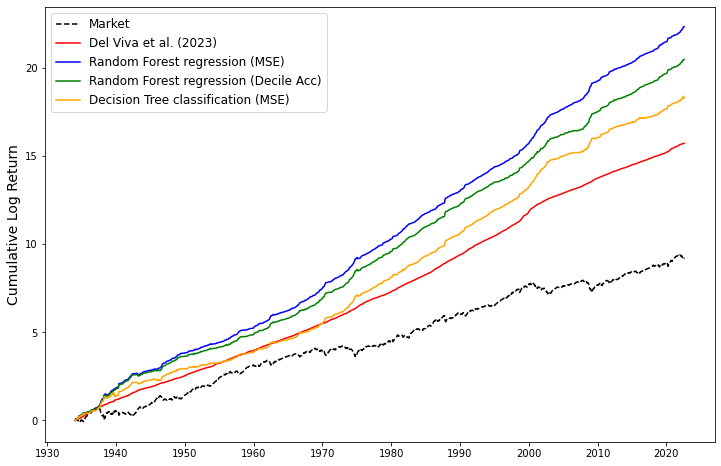

In [31]:
# Plot cumulative log returns for best_models


from matplotlib import lines


plt.figure(figsize=(12, 8))
#for model in best_models:
#    plt.plot(cum_log_ret.index, cum_log_ret[model], label=model)

#plot the 'l_Mkt' from cum_log_ret
plt.plot(cum_log_ret.index, cum_log_ret['l_Mkt'], label='Market', color='black', linestyle='dashed')

# plot 'l_ols_default' from cum_log_ret
plt.plot(cum_log_ret.index, cum_log_ret['l_base_ols_default'], label='Del Viva et al. (2023)', color='red')

# l_RF_reg_roll5_MSE from cum_log_ret
plt.plot(cum_log_ret.index, cum_log_ret['l_RF_reg_roll5_MSE'], label='Random Forest regression (MSE)', color='blue')

# l_RF_reg_roll5 from cum_log_ret
plt.plot(cum_log_ret.index, cum_log_ret['l_RF_reg_roll5'], label='Random Forest regression (Decile Acc)', color='green')

# plot l_DT_class_roll5_MSE from cum_log_ret
plt.plot(cum_log_ret.index, cum_log_ret['l_DT_class_roll5_MSE'], label='Decision Tree classification (MSE)', color='orange')




plt.ylabel('Cumulative Log Return', fontsize=14)
plt.legend(fontsize=12)
plt.show()


### From log returns to normal returns

In [32]:
# Copy the DataFrame to keep the date column unchanged
normal_ret = log_ret.copy()

# Apply the conversion to all columns except 'date'
for col in normal_ret.columns:
    if col != 'date':
        normal_ret[col] = np.exp(normal_ret[col]) - 1

# Display the head of the updated DataFrame to verify the changes
normal_ret.head()

,l_ols_default,l_ridge_reg_roll5,l_lasso_reg_roll5,l_DT_reg_roll5,l_RF_reg_roll5,l_Mkt,l_base_ols_default,l_ridge_clas_roll5,l_DT_class_roll5,l_RF_class_roll5,l_lasso_clas_roll5,l_ridge_reg_roll5_MSE,l_lasso_reg_roll5_MSE,l_DT_reg_roll5_MSE,l_RF_reg_roll5_MSE,l_ridge_clas_roll5_MSE,l_DT_class_roll5_MSE,l_RF_class_roll5_MSE,l_lasso_clas_roll5_MSE
date,,,,,,,,,,,,,,,,,,,
1934-01-31,0.009212,0.004237,-0.024571,-0.004515,-0.002631,0.1265,0.029955,0.001818,-0.004515,0.018442,0.005515,0.005550,-0.024571,-0.004515,-0.002631,0.003769,-0.004515,0.006121,-0.006797
1934-02-28,0.008458,0.011607,0.006036,0.033750,0.033750,-0.0248,0.011946,0.010760,0.034978,0.009839,0.008184,0.009891,0.006036,0.033750,0.033750,0.001935,0.033750,0.011718,0.001653
1934-03-31,0.007722,0.007676,0.005021,0.014576,0.014608,0.0011,0.007732,0.007759,0.015288,0.008641,0.007784,0.007660,0.005021,0.014576,0.014608,0.008154,0.014576,0.009141,0.005535
1934-04-30,0.018504,0.018343,0.015074,0.030129,0.030452,-0.0178,0.015612,0.018992,0.030673,0.009864,0.019593,0.018385,0.015074,0.030129,0.030452,0.019720,0.030129,0.010288,0.018181
1934-05-31,0.023362,0.024285,0.024675,0.071569,0.071675,-0.0724,0.019262,0.024475,0.071682,0.020963,0.024800,0.024495,0.024675,0.071569,0.071675,0.025835,0.071569,0.013411,0.025804


In [33]:
normal_ret.rename(columns={col: col.replace('l_', '') if col != 'date' else col for col in normal_ret.columns}, inplace=True)
normal_ret.head()

,ols_default,ridge_reg_roll5,lasso_reg_roll5,DT_reg_roll5,RF_reg_roll5,Mkt,base_ols_default,ridge_clas_roll5,DT_class_roll5,RF_class_roll5,lasso_clas_roll5,ridge_reg_roll5_MSE,lasso_reg_roll5_MSE,DT_reg_roll5_MSE,RF_reg_roll5_MSE,ridge_clas_roll5_MSE,DT_class_roll5_MSE,RF_class_roll5_MSE,lasso_clas_roll5_MSE
date,,,,,,,,,,,,,,,,,,,
1934-01-31,0.009212,0.004237,-0.024571,-0.004515,-0.002631,0.1265,0.029955,0.001818,-0.004515,0.018442,0.005515,0.005550,-0.024571,-0.004515,-0.002631,0.003769,-0.004515,0.006121,-0.006797
1934-02-28,0.008458,0.011607,0.006036,0.033750,0.033750,-0.0248,0.011946,0.010760,0.034978,0.009839,0.008184,0.009891,0.006036,0.033750,0.033750,0.001935,0.033750,0.011718,0.001653
1934-03-31,0.007722,0.007676,0.005021,0.014576,0.014608,0.0011,0.007732,0.007759,0.015288,0.008641,0.007784,0.007660,0.005021,0.014576,0.014608,0.008154,0.014576,0.009141,0.005535
1934-04-30,0.018504,0.018343,0.015074,0.030129,0.030452,-0.0178,0.015612,0.018992,0.030673,0.009864,0.019593,0.018385,0.015074,0.030129,0.030452,0.019720,0.030129,0.010288,0.018181
1934-05-31,0.023362,0.024285,0.024675,0.071569,0.071675,-0.0724,0.019262,0.024475,0.071682,0.020963,0.024800,0.024495,0.024675,0.071569,0.071675,0.025835,0.071569,0.013411,0.025804


## Bringing in the market data, factors

In [34]:
# load csv from "C:\Users\tomta\Tomas\School\03_Magistr\02_Business Analytics\10_BA_Thesis\03_Modeling\02_Sign prediction\FF3_clean.csv"
ff3 = pd.read_csv('C:\\Users\\tomta\\Tomas\\School\\03_Magistr\\02_Business Analytics\\10_BA_Thesis\\03_Modeling\\02_Sign prediction\\FF3_clean.csv')
ff5 = pd.read_csv('C:\\Users\\tomta\\Tomas\\School\\03_Magistr\\02_Business Analytics\\10_BA_Thesis\\03_Modeling\\02_Sign prediction\\FF5_clean.csv')

In [35]:
ff3.head()

,date,Mkt-RF,SMB,HML,RF
0,1926-07-31,2.96,-2.56,-2.43,0.22
1,1926-08-31,2.64,-1.17,3.82,0.25
2,1926-09-30,0.36,-1.40,0.13,0.23
3,1926-10-31,-3.24,-0.09,0.70,0.32
4,1926-11-30,2.53,-0.10,-0.51,0.31


In [36]:
ff3['date'] = pd.to_datetime(ff3['date'])
ff5['date'] = pd.to_datetime(ff5['date'])

# rename SMB and HML columns in ff3 to SMB3 and HML3
ff3.rename(columns={'SMB': 'SMB3', 'HML': 'HML3'}, inplace=True)

# rename SMB and HML columns in ff5 to SMB5 and HML5 and RMW and CMA to RMW5 and CMA5
ff5.rename(columns={'SMB': 'SMB5', 'HML': 'HML5', 'RMW': 'RMW5', 'CMA': 'CMA5'}, inplace=True)

# drop the Mkt-RF and RF column from ff5
ff5 = ff5.drop(['Mkt-RF', 'RF'], axis=1)

# divide all columns in ff3 by 100 (except for the date column)
ff3.iloc[:, 1:] = ff3.iloc[:, 1:] / 100


# merge the ff3 and ff5 DataFrames to one dataframe
factors = pd.merge(ff3, ff5, on='date', how='left')

factors.tail()

,date,Mkt-RF,SMB3,HML3,RF,SMB5,HML5,RMW5,CMA5
1165,2023-08-31,-0.0239,-0.0316,-0.0106,0.0045,-0.0365,-0.0106,0.0343,-0.0237
1166,2023-09-30,-0.0524,-0.0251,0.0152,0.0043,-0.0180,0.0152,0.0186,-0.0083
1167,2023-10-31,-0.0319,-0.0387,0.0019,0.0047,-0.0404,0.0019,0.0246,-0.0066
1168,2023-11-30,0.0884,-0.0002,0.0164,0.0044,-0.0012,0.0164,-0.0391,-0.0100
1169,2023-12-31,0.0485,0.0635,0.0494,0.0043,0.0732,0.0494,-0.0307,0.0132


In [37]:
models = normal_ret.columns
models.drop('Mkt')

Index(['ols_default', 'ridge_reg_roll5', 'lasso_reg_roll5', 'DT_reg_roll5',
       'RF_reg_roll5', 'base_ols_default', 'ridge_clas_roll5',
       'DT_class_roll5', 'RF_class_roll5', 'lasso_clas_roll5',
       'ridge_reg_roll5_MSE', 'lasso_reg_roll5_MSE', 'DT_reg_roll5_MSE',
       'RF_reg_roll5_MSE', 'ridge_clas_roll5_MSE', 'DT_class_roll5_MSE',
       'RF_class_roll5_MSE', 'lasso_clas_roll5_MSE'],
      dtype='object')

In [38]:
# merge ff3 to normal_ret on 'date'
normal_ret = normal_ret.merge(factors, on='date', how='inner')

normal_ret.head()

,date,ols_default,ridge_reg_roll5,lasso_reg_roll5,DT_reg_roll5,RF_reg_roll5,Mkt,base_ols_default,ridge_clas_roll5,DT_class_roll5,RF_class_roll5,lasso_clas_roll5,ridge_reg_roll5_MSE,lasso_reg_roll5_MSE,DT_reg_roll5_MSE,RF_reg_roll5_MSE,ridge_clas_roll5_MSE,DT_class_roll5_MSE,RF_class_roll5_MSE,lasso_clas_roll5_MSE,Mkt-RF,SMB3,HML3,RF,SMB5,HML5,RMW5,CMA5
0,1934-01-31,0.009212,0.004237,-0.024571,-0.004515,-0.002631,0.1265,0.029955,0.001818,-0.004515,0.018442,0.005515,0.005550,-0.024571,-0.004515,-0.002631,0.003769,-0.004515,0.006121,-0.006797,0.1260,0.1269,0.1559,0.0005,NaN,NaN,NaN,NaN
1,1934-02-28,0.008458,0.011607,0.006036,0.033750,0.033750,-0.0248,0.011946,0.010760,0.034978,0.009839,0.008184,0.009891,0.006036,0.033750,0.033750,0.001935,0.033750,0.011718,0.001653,-0.0250,0.0510,0.0200,0.0002,NaN,NaN,NaN,NaN
2,1934-03-31,0.007722,0.007676,0.005021,0.014576,0.014608,0.0011,0.007732,0.007759,0.015288,0.008641,0.007784,0.007660,0.005021,0.014576,0.014608,0.008154,0.014576,0.009141,0.005535,0.0009,0.0251,-0.0270,0.0002,NaN,NaN,NaN,NaN
3,1934-04-30,0.018504,0.018343,0.015074,0.030129,0.030452,-0.0178,0.015612,0.018992,0.030673,0.009864,0.019593,0.018385,0.015074,0.030129,0.030452,0.019720,0.030129,0.010288,0.018181,-0.0179,0.0273,-0.0373,0.0001,NaN,NaN,NaN,NaN
4,1934-05-31,0.023362,0.024285,0.024675,0.071569,0.071675,-0.0724,0.019262,0.024475,0.071682,0.020963,0.024800,0.024495,0.024675,0.071569,0.071675,0.025835,0.071569,0.013411,0.025804,-0.0725,-0.0029,-0.0589,0.0001,NaN,NaN,NaN,NaN


In [39]:
normal_ret.tail()

,date,ols_default,ridge_reg_roll5,lasso_reg_roll5,DT_reg_roll5,RF_reg_roll5,Mkt,base_ols_default,ridge_clas_roll5,DT_class_roll5,RF_class_roll5,lasso_clas_roll5,ridge_reg_roll5_MSE,lasso_reg_roll5_MSE,DT_reg_roll5_MSE,RF_reg_roll5_MSE,ridge_clas_roll5_MSE,DT_class_roll5_MSE,RF_class_roll5_MSE,lasso_clas_roll5_MSE,Mkt-RF,SMB3,HML3,RF,SMB5,HML5,RMW5,CMA5
1055,2022-03-31,0.013454,0.013564,0.002295,0.015193,0.015193,0.0306,0.014639,0.013753,-0.016202,0.013826,0.013774,0.013718,0.002295,0.015193,0.015480,0.002246,0.015193,0.013834,0.002250,0.0305,-0.0161,-0.0181,0.0001,-0.0217,-0.0181,-0.0153,0.0314
1056,2022-04-30,0.010321,0.009996,0.005953,0.088647,0.088647,-0.0945,0.010195,0.011051,0.088647,0.015805,0.011716,0.009619,0.005953,0.088647,0.088647,0.011621,0.088647,0.020885,0.011661,-0.0946,-0.0139,0.0617,0.0001,-0.0039,0.0617,0.0352,0.0589
1057,2022-05-31,0.009911,0.009780,0.002204,0.001195,0.001195,-0.0031,0.010948,0.010744,0.001195,0.011058,0.010273,0.010080,0.002204,0.001195,0.026663,0.008969,0.001195,0.017490,0.008988,-0.0034,-0.0183,0.0839,0.0003,-0.0006,0.0839,0.0156,0.0397
1058,2022-06-30,0.007437,0.007688,0.006251,0.078736,0.078736,-0.0837,0.005976,0.007865,0.078736,0.007082,0.007985,0.007902,0.006251,0.078736,0.081993,0.007614,0.078736,0.017306,0.007405,-0.0843,0.0210,-0.0597,0.0006,0.0130,-0.0597,0.0181,-0.0469
1059,2022-07-31,0.014332,0.013665,0.001415,-0.095818,0.004292,0.0965,0.011411,0.009988,-0.095818,0.014630,0.008218,0.022262,0.001415,-0.095818,0.004644,0.001495,-0.095818,0.010941,0.002054,0.0957,0.0281,-0.0405,0.0008,0.0182,-0.0405,0.0082,-0.0683


### Make some plots - return distributions

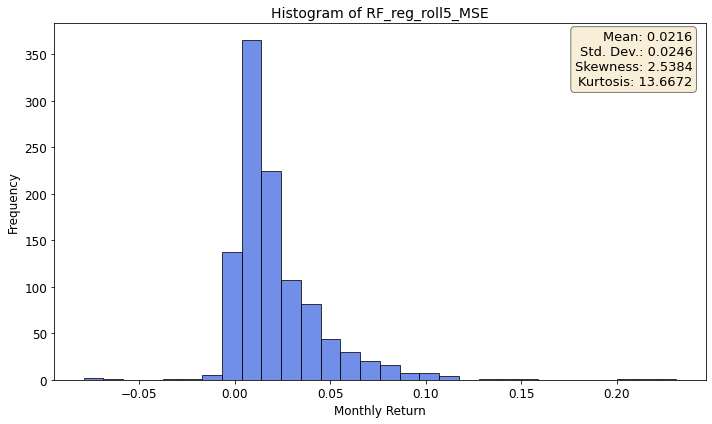

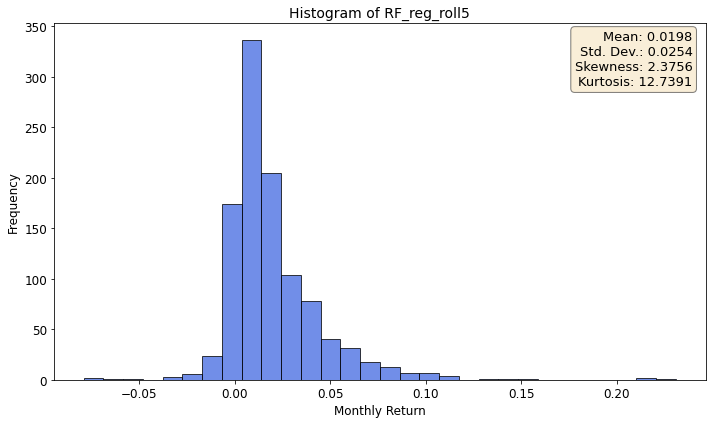

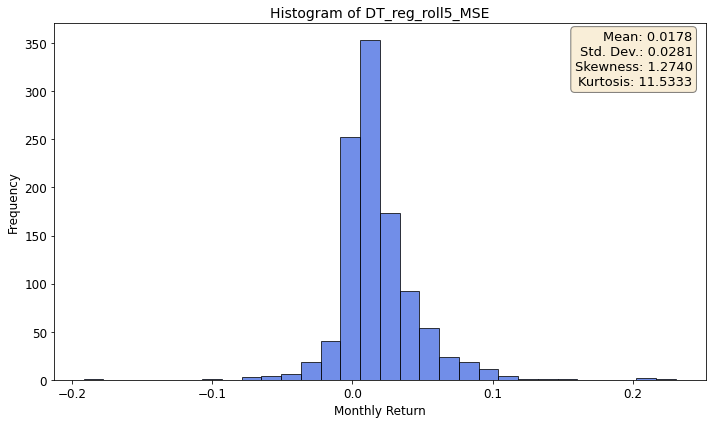

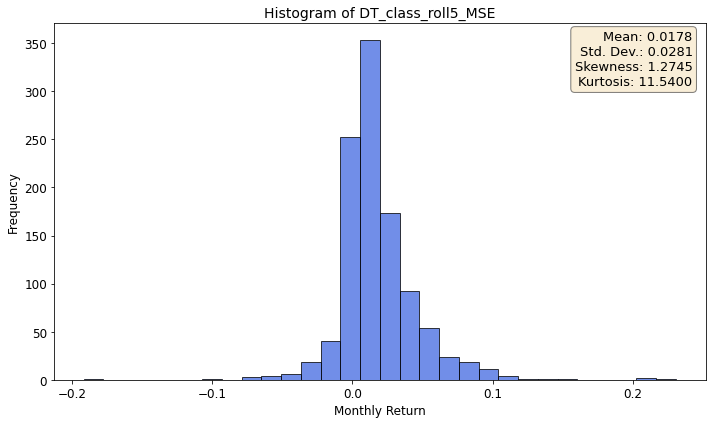

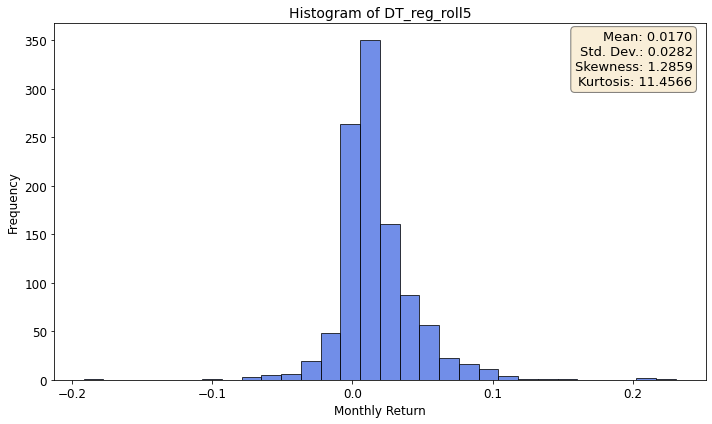

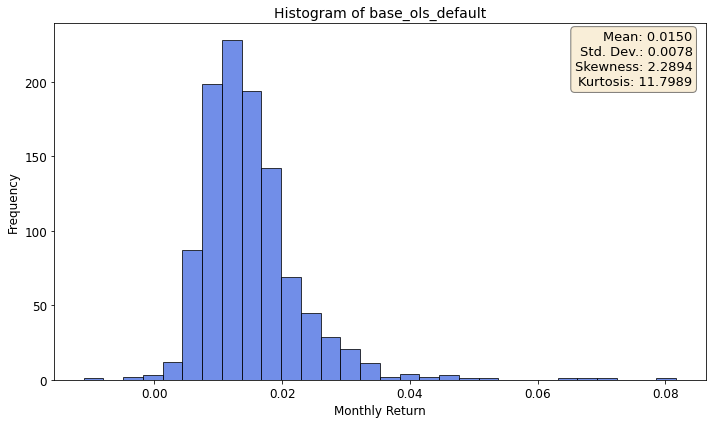

In [40]:
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import skew, kurtosis

# Assuming 'normal_ret' is your DataFrame and it's already loaded

def plot_histograms_separately(df, columns, bins=30, color='royalblue'):
    for column in columns:
        if column not in df.columns:
            print(f"Column '{column}' not found in DataFrame.")
            continue

        fig, ax = plt.subplots(figsize=(10, 6))
        values = df[column] 
        mean_val = values.mean()
        std_dev_val = values.std()
        skewness_val = skew(values)
        kurtosis_val = kurtosis(values)

        ax.hist(values, bins=bins, alpha=0.75, color=color, edgecolor='black')
        ax.set_title(f'Histogram of {column}', fontsize=14)
        ax.set_xlabel('Monthly Return', fontsize=12)
        ax.set_ylabel('Frequency', fontsize=12)
        ax.xaxis.set_tick_params(labelsize=12)
        ax.yaxis.set_tick_params(labelsize=12)


        # Annotating the plot with statistical values
        stats_text = f'Mean: {mean_val:.4f}\nStd. Dev.: {std_dev_val:.4f}\nSkewness: {skewness_val:.4f}\nKurtosis: {kurtosis_val:.4f}'
        ax.text(0.98, 0.98, stats_text, transform=ax.transAxes, verticalalignment='top', horizontalalignment='right', fontsize=13, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

        plt.tight_layout()
        plt.show()



selected_columns = [model[2:] for model in best_models]

plot_histograms_separately(normal_ret, selected_columns)


In [41]:
# for each column, calculate the average of the column and store in a new DataFrame

avg_ret = normal_ret.mean()

# rename the column to 'avg_ret' and index to 'model'
avg_ret = avg_ret.to_frame().reset_index()
avg_ret.columns = ['model', 'avg_ret']

# round the values in the 'avg_ret' column to 3 decimal places
avg_ret['avg_ret'] = avg_ret['avg_ret'].round(3)


avg_ret.head()

<ipython-input-41-fcce1330845f>:3: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  avg_ret = normal_ret.mean()


,model,avg_ret
0,ols_default,0.015
1,ridge_reg_roll5,0.015
2,lasso_reg_roll5,0.005
3,DT_reg_roll5,0.017
4,RF_reg_roll5,0.020


In [42]:
excess_ret = normal_ret.copy()

# Calculate excess return (i.e. subtract the RF column) for columns in 'models' list
for model in models:
    excess_ret[model] = excess_ret[model] - excess_ret['RF']


excess_ret.head()


,date,ols_default,ridge_reg_roll5,lasso_reg_roll5,DT_reg_roll5,RF_reg_roll5,Mkt,base_ols_default,ridge_clas_roll5,DT_class_roll5,RF_class_roll5,lasso_clas_roll5,ridge_reg_roll5_MSE,lasso_reg_roll5_MSE,DT_reg_roll5_MSE,RF_reg_roll5_MSE,ridge_clas_roll5_MSE,DT_class_roll5_MSE,RF_class_roll5_MSE,lasso_clas_roll5_MSE,Mkt-RF,SMB3,HML3,RF,SMB5,HML5,RMW5,CMA5
0,1934-01-31,0.008712,0.003737,-0.025071,-0.005015,-0.003131,0.1260,0.029455,0.001318,-0.005015,0.017942,0.005015,0.005050,-0.025071,-0.005015,-0.003131,0.003269,-0.005015,0.005621,-0.007297,0.1260,0.1269,0.1559,0.0005,NaN,NaN,NaN,NaN
1,1934-02-28,0.008258,0.011407,0.005836,0.033550,0.033550,-0.0250,0.011746,0.010560,0.034778,0.009639,0.007984,0.009691,0.005836,0.033550,0.033550,0.001735,0.033550,0.011518,0.001453,-0.0250,0.0510,0.0200,0.0002,NaN,NaN,NaN,NaN
2,1934-03-31,0.007522,0.007476,0.004821,0.014376,0.014408,0.0009,0.007532,0.007559,0.015088,0.008441,0.007584,0.007460,0.004821,0.014376,0.014408,0.007954,0.014376,0.008941,0.005335,0.0009,0.0251,-0.0270,0.0002,NaN,NaN,NaN,NaN
3,1934-04-30,0.018404,0.018243,0.014974,0.030029,0.030352,-0.0179,0.015512,0.018892,0.030573,0.009764,0.019493,0.018285,0.014974,0.030029,0.030352,0.019620,0.030029,0.010188,0.018081,-0.0179,0.0273,-0.0373,0.0001,NaN,NaN,NaN,NaN
4,1934-05-31,0.023262,0.024185,0.024575,0.071469,0.071575,-0.0725,0.019162,0.024375,0.071582,0.020863,0.024700,0.024395,0.024575,0.071469,0.071575,0.025735,0.071469,0.013311,0.025704,-0.0725,-0.0029,-0.0589,0.0001,NaN,NaN,NaN,NaN


In [43]:
# save the excess_ret DataFrame to a .dta file
excess_ret.to_csv('base_excess_ret.csv', index=False)

### Calculating Sharpe Ratios and Abnormal Returns


In [44]:
import statsmodels.api as sm

In [45]:
models = excess_ret.columns
models = models.drop(['date', 'Mkt', 'SMB3', 'HML3', 'RF', 'SMB5', 'HML5', 'RMW5', 'CMA5', 'Mkt-RF'])

# Initialize DataFrame to hold all results
backtest = pd.DataFrame(columns=['Model', 'Ann_Sharpe', 'CAPM_a', 'CAPM_p', 'FF3_a', 'FF3_p', 'FF5_a', 'FF5_p'])

# Prepare X variables for CAPM and Three-Factor models outside the loop
X_capm = sm.add_constant(excess_ret['Mkt-RF'])  # CAPM
X_ff3 = sm.add_constant(excess_ret[['Mkt-RF', 'SMB3', 'HML3']])  # Three-Factor

# Drop rows with NaN values in Five-Factor model variables
X_ff5_clean = excess_ret[['Mkt-RF', 'SMB5', 'HML5', 'RMW5', 'CMA5']].dropna()
X_ff5 = sm.add_constant(X_ff5_clean)  # Five-Factor

for model in models:
    # Assuming y might contain NaNs, drop them for alignment
    y = excess_ret[model]
    
    # Ensure alignment of y with each X variable
    # CAPM model fit
    aligned_X_capm = X_capm.loc[y.index]
    capm_results = sm.OLS(y, aligned_X_capm).fit()
    
    # Three-Factor model fit
    aligned_X_ff3 = X_ff3.loc[y.index]
    ff3_results = sm.OLS(y, aligned_X_ff3).fit()
    
    # Five-Factor model fit, ensuring alignment with the clean X_ff5 index
    aligned_X_ff5 = X_ff5.loc[X_ff5.index.intersection(y.index)]
    y_aligned_ff5 = y.loc[aligned_X_ff5.index]
    ff5_results = sm.OLS(y_aligned_ff5, aligned_X_ff5).fit()
    
    # Calculate and round the annualized Sharpe ratio
    mean_excess_return = y.mean()
    std_dev_excess_returns = y.std()
    ann_sharpe = round((mean_excess_return/std_dev_excess_returns) * np.sqrt(12), 2)  # Square root of 12 for monthly data
    
    # Round alpha and p-values
    capm_a = round(capm_results.params[0], 3)
    capm_p = round(capm_results.pvalues[0], 3)
    ff3_a = round(ff3_results.params[0], 3)
    ff3_p = round(ff3_results.pvalues[0], 3)
    ff5_a = round(ff5_results.params[0], 3)
    ff5_p = round(ff5_results.pvalues[0], 3)
    
    # Append results to the DataFrame
    backtest = backtest.append({
        'Model': model,
        'Ann_Sharpe': ann_sharpe/10,
        'CAPM_a': capm_a,
        'CAPM_p': capm_p,
        'FF3_a': ff3_a,
        'FF3_p': ff3_p,
        'FF5_a': ff5_a,
        'FF5_p': ff5_p,
    }, ignore_index=True)


# drop the row where the model is 'Mkt'
#backtest = backtest[backtest['Model'] != 'Mkt']

# Display the compiled results
backtest.head(10)


,Model,Ann_Sharpe,CAPM_a,CAPM_p,FF3_a,FF3_p,FF5_a,FF5_p
0,ols_default,0.546,0.012,0.0,0.012,0.0,0.012,0.0
1,ridge_reg_roll5,0.539,0.012,0.0,0.012,0.0,0.012,0.0
2,lasso_reg_roll5,0.058,0.003,0.0,0.003,0.0,0.001,0.0
3,DT_reg_roll5,0.176,0.018,0.0,0.018,0.0,0.018,0.0
4,RF_reg_roll5,0.234,0.020,0.0,0.020,0.0,0.020,0.0
5,base_ols_default,0.544,0.012,0.0,0.012,0.0,0.012,0.0
6,ridge_clas_roll5,0.419,0.009,0.0,0.009,0.0,0.009,0.0
7,DT_class_roll5,0.047,0.010,0.0,0.010,0.0,0.009,0.0
8,RF_class_roll5,0.438,0.011,0.0,0.011,0.0,0.012,0.0
9,lasso_clas_roll5,0.285,0.006,0.0,0.006,0.0,0.004,0.0


In [46]:
backtest.sort_values('Ann_Sharpe', ascending=False, inplace=True)

In [47]:
# round the total_cum_logret column to 4 decimal places
final_log_ret_df['total_cum_logret'] = final_log_ret_df['total_cum_logret'].round(3)

# if the value in the column "model" of final_log_ret_df starts with "l_" then remove the "l_" from the value
final_log_ret_df['model'] = final_log_ret_df['model'].apply(lambda x: x[2:] if x.startswith('l_') else x)

# merge with avg_ret DataFrame on the 'model' column
backtest = backtest.merge(avg_ret, left_on='Model', right_on='model', how='left')

# remove the model column
backtest.drop('model', axis=1, inplace=True)

# drop row where Model is ols_default_x	
backtest = backtest[backtest['Model'] != 'ols_default_x']


backtest.head(50)



,Model,Ann_Sharpe,CAPM_a,CAPM_p,FF3_a,FF3_p,FF5_a,FF5_p,avg_ret
0,ols_default,0.546,0.012,0.0,0.012,0.0,0.012,0.0,0.015
1,base_ols_default,0.544,0.012,0.0,0.012,0.0,0.012,0.0,0.015
2,ridge_reg_roll5,0.539,0.012,0.0,0.012,0.0,0.012,0.0,0.015
3,ridge_reg_roll5_MSE,0.535,0.011,0.0,0.011,0.0,0.012,0.0,0.014
4,RF_class_roll5,0.438,0.011,0.0,0.011,0.0,0.012,0.0,0.014
5,ridge_clas_roll5,0.419,0.009,0.0,0.009,0.0,0.009,0.0,0.012
6,RF_class_roll5_MSE,0.386,0.010,0.0,0.010,0.0,0.010,0.0,0.012
7,ridge_clas_roll5_MSE,0.291,0.006,0.0,0.006,0.0,0.004,0.0,0.008
8,lasso_clas_roll5,0.285,0.006,0.0,0.006,0.0,0.004,0.0,0.008
9,RF_reg_roll5_MSE,0.266,0.022,0.0,0.022,0.0,0.022,0.0,0.022


In [48]:
# merge the final_log_ret_df and backtest DataFrames on the 'model' column
backtest = backtest.merge(final_log_ret_df, left_on='Model', right_on='model', how='left')

# remove the model column
backtest.drop('model', axis=1, inplace=True)

backtest.head(10)

,Model,Ann_Sharpe,CAPM_a,CAPM_p,FF3_a,FF3_p,FF5_a,FF5_p,avg_ret,total_cum_logret,Type,Metric,Algorithm
0,ols_default,0.546,0.012,0.0,0.012,0.0,0.012,0.0,0.015,15.366,reg,acc,ols
1,base_ols_default,0.544,0.012,0.0,0.012,0.0,0.012,0.0,0.015,15.714,reg,acc,ols
2,ridge_reg_roll5,0.539,0.012,0.0,0.012,0.0,0.012,0.0,0.015,15.537,reg,acc,ridge
3,ridge_reg_roll5_MSE,0.535,0.011,0.0,0.011,0.0,0.012,0.0,0.014,15.227,reg,mse,ridge
4,RF_class_roll5,0.438,0.011,0.0,0.011,0.0,0.012,0.0,0.014,14.251,class,acc,RF
5,ridge_clas_roll5,0.419,0.009,0.0,0.009,0.0,0.009,0.0,0.012,12.386,class,acc,ridge
6,RF_class_roll5_MSE,0.386,0.010,0.0,0.010,0.0,0.010,0.0,0.012,12.648,class,mse,RF
7,ridge_clas_roll5_MSE,0.291,0.006,0.0,0.006,0.0,0.004,0.0,0.008,8.666,class,mse,ridge
8,lasso_clas_roll5,0.285,0.006,0.0,0.006,0.0,0.004,0.0,0.008,8.947,class,acc,other
9,RF_reg_roll5_MSE,0.266,0.022,0.0,0.022,0.0,0.022,0.0,0.022,22.323,reg,mse,RF


In [49]:
# save the backtest into parquet
backtest.to_parquet('backtest.parquet')

In [50]:
# sort the backtest using Ann_sharpe in descending order
backtest.sort_values('Ann_Sharpe', ascending=False, inplace=True)
backtest.head(30)

,Model,Ann_Sharpe,CAPM_a,CAPM_p,FF3_a,FF3_p,FF5_a,FF5_p,avg_ret,total_cum_logret,Type,Metric,Algorithm
0,ols_default,0.546,0.012,0.0,0.012,0.0,0.012,0.0,0.015,15.366,reg,acc,ols
1,base_ols_default,0.544,0.012,0.0,0.012,0.0,0.012,0.0,0.015,15.714,reg,acc,ols
2,ridge_reg_roll5,0.539,0.012,0.0,0.012,0.0,0.012,0.0,0.015,15.537,reg,acc,ridge
3,ridge_reg_roll5_MSE,0.535,0.011,0.0,0.011,0.0,0.012,0.0,0.014,15.227,reg,mse,ridge
4,RF_class_roll5,0.438,0.011,0.0,0.011,0.0,0.012,0.0,0.014,14.251,class,acc,RF
5,ridge_clas_roll5,0.419,0.009,0.0,0.009,0.0,0.009,0.0,0.012,12.386,class,acc,ridge
6,RF_class_roll5_MSE,0.386,0.010,0.0,0.010,0.0,0.010,0.0,0.012,12.648,class,mse,RF
7,ridge_clas_roll5_MSE,0.291,0.006,0.0,0.006,0.0,0.004,0.0,0.008,8.666,class,mse,ridge
8,lasso_clas_roll5,0.285,0.006,0.0,0.006,0.0,0.004,0.0,0.008,8.947,class,acc,other
9,RF_reg_roll5_MSE,0.266,0.022,0.0,0.022,0.0,0.022,0.0,0.022,22.323,reg,mse,RF


In [51]:
# print the average annualized Sharpe ratio for each type and method
print(backtest.groupby(['Type', 'Metric'])['Ann_Sharpe'].mean())

Type   Metric
class  acc       0.29725
       mse       0.25950
reg    acc       0.34950
       mse       0.26200
Name: Ann_Sharpe, dtype: float64


In [52]:
# Convert categorical variables into dummy variables
backtest_dummies = pd.get_dummies(backtest, columns=['Type', 'Metric', 'Algorithm'])

# Define the base formula components excluding CAPM, FF3, and FF5 related columns
base_formula_components = ['Type', 'Metric', 'Algorithm']

# Construct the formula for Sharpe Ratio regression
formula_sharpe = 'Ann_Sharpe ~ ' + ' + '.join([f'C({component})' for component in base_formula_components])

# Construct the formula for Total Cumulative Logarithmic Return regression
formula_logret = 'total_cum_logret ~ ' + ' + '.join([f'C({component})' for component in base_formula_components])

# Perform the regression for Sharpe Ratio
model_sharpe = smf.ols(formula=formula_sharpe, data=backtest).fit()

# Perform the regression for Total Cumulative Logarithmic Return
model_logret = smf.ols(formula=formula_logret, data=backtest).fit()

# Print the summary tables for both regressions
print("Regression for Sharpe Ratio:\n", model_sharpe.summary())
print("\nRegression for Total Cumulative Logarithmic Return:\n", model_logret.summary())


Regression for Sharpe Ratio:
                             OLS Regression Results                            
Dep. Variable:             Ann_Sharpe   R-squared:                       0.775
Model:                            OLS   Adj. R-squared:                  0.652
Method:                 Least Squares   F-statistic:                     6.312
Date:                Wed, 06 Mar 2024   Prob (F-statistic):            0.00438
Time:                        13:06:46   Log-Likelihood:                 19.854
No. Observations:                  18   AIC:                            -25.71
Df Residuals:                      11   BIC:                            -19.47
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------


c:\Users\tomta\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
c:\Users\tomta\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [53]:
backtest = backtest.merge(metrics_df[['Accuracy', 'MAE', 'MSE']], left_on='Model', right_index=True, how='left')
backtest.rename(columns={'Accuracy': 'Acc_tot', 'MAE': 'MAE_tot', 'MSE': 'MSE_tot'}, inplace=True)
backtest = backtest.merge(metrics_decile[['Accuracy', 'MAE', 'MSE']], left_on='Model', right_index=True, how='left')
backtest.rename(columns={'Accuracy': 'Acc_dec', 'MAE': 'MAE_dec', 'MSE': 'MSE_dec'}, inplace=True)
backtest.head()

,Model,Ann_Sharpe,CAPM_a,CAPM_p,FF3_a,FF3_p,FF5_a,FF5_p,avg_ret,total_cum_logret,Type,Metric,Algorithm,Acc_tot,MAE_tot,MSE_tot,Acc_dec,MAE_dec,MSE_dec
0,ols_default,0.546,0.012,0.0,0.012,0.0,0.012,0.0,0.015,15.366,reg,acc,ols,0.866633,0.333716,0.142686,0.978147,0.213724,0.105328
1,base_ols_default,0.544,0.012,0.0,0.012,0.0,0.012,0.0,0.015,15.714,reg,acc,ols,0.827494,0.350322,0.151445,0.977301,0.214349,0.087849
2,ridge_reg_roll5,0.539,0.012,0.0,0.012,0.0,0.012,0.0,0.015,15.537,reg,acc,ridge,0.830198,0.342816,0.149127,0.979427,0.207129,0.086630
3,ridge_reg_roll5_MSE,0.535,0.011,0.0,0.011,0.0,0.012,0.0,0.014,15.227,reg,mse,ridge,0.839889,0.339268,0.149119,0.977651,0.215266,0.099218
4,RF_class_roll5,0.438,0.011,0.0,0.011,0.0,0.012,0.0,0.014,14.251,class,acc,RF,0.970231,0.092549,0.027782,0.998134,0.018760,0.002126


In [54]:
# OLS: Ann_Sharpe ~ Acc_tot
model_acc_tot = smf.ols(formula='Ann_Sharpe ~ Acc_tot', data=backtest).fit()

# OLS: Ann_Sharpe ~ Acc_dec
model_acc_dec = smf.ols(formula='Ann_Sharpe ~ Acc_dec', data=backtest).fit()

# OLS: Ann_Sharpe ~ MSE_tot
model_mse_tot = smf.ols(formula='Ann_Sharpe ~ MSE_tot', data=backtest).fit()

# OLS: Ann_Sharpe ~ MSE_dec
model_mse_dec = smf.ols(formula='Ann_Sharpe ~ MSE_dec', data=backtest).fit()

# print the summary tables for both regressions
print("Regression for Ann_Sharpe ~ Acc_tot:\n", model_acc_tot.summary())
print("\nRegression for Ann_Sharpe ~ Acc_dec:\n", model_acc_dec.summary())
print("\nRegression for Ann_Sharpe ~ MSE_tot:\n", model_mse_tot.summary())
print("\nRegression for Ann_Sharpe ~ MSE_dec:\n", model_mse_dec.summary())



Regression for Ann_Sharpe ~ Acc_tot:
                             OLS Regression Results                            
Dep. Variable:             Ann_Sharpe   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                 -0.030
Method:                 Least Squares   F-statistic:                    0.5046
Date:                Wed, 06 Mar 2024   Prob (F-statistic):              0.488
Time:                        13:06:46   Log-Likelihood:                 6.7114
No. Observations:                  18   AIC:                            -9.423
Df Residuals:                      16   BIC:                            -7.642
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     

c:\Users\tomta\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
c:\Users\tomta\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
c:\Users\tomta\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
c:\Users\tomta\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "



Regression for Ann_Sharpe ~ Acc_dec:
                             OLS Regression Results                            
Dep. Variable:             Ann_Sharpe   R-squared:                       0.359
Model:                            OLS   Adj. R-squared:                  0.319
Method:                 Least Squares   F-statistic:                     8.978
Date:                Wed, 06 Mar 2024   Prob (F-statistic):            0.00855
Time:                        13:06:46   Log-Likelihood:                 10.440
No. Observations:                  18   AIC:                            -16.88
Df Residuals:                      16   BIC:                            -15.10
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    

In [55]:
# OLS: total_cum_logret ~ Acc_tot
model_logret_acc_tot = smf.ols(formula='total_cum_logret ~ Acc_tot', data=backtest).fit()

# OLS: total_cum_logret ~ Acc_dec
model_logret_acc_dec = smf.ols(formula='total_cum_logret ~ Acc_dec', data=backtest).fit()

# OLS: total_cum_logret ~ MSE_tot
model_logret_mse_tot = smf.ols(formula='total_cum_logret ~ MSE_tot', data=backtest).fit()

# OLS: total_cum_logret ~ MSE_dec
model_logret_mse_dec = smf.ols(formula='total_cum_logret ~ MSE_dec', data=backtest).fit()

# print the summary tables for both regressions
print("Regression for total_cum_logret ~ Acc_tot:\n", model_logret_acc_tot.summary())
print("\nRegression for total_cum_logret ~ Acc_dec:\n", model_logret_acc_dec.summary())
print("\nRegression for total_cum_logret ~ MSE_tot:\n", model_logret_mse_tot.summary())
print("\nRegression for total_cum_logret ~ MSE_dec:\n", model_logret_mse_dec.summary())


Regression for total_cum_logret ~ Acc_tot:
                             OLS Regression Results                            
Dep. Variable:       total_cum_logret   R-squared:                       0.173
Model:                            OLS   Adj. R-squared:                  0.121
Method:                 Least Squares   F-statistic:                     3.343
Date:                Wed, 06 Mar 2024   Prob (F-statistic):             0.0862
Time:                        13:06:46   Log-Likelihood:                -53.726
No. Observations:                  18   AIC:                             111.5
Df Residuals:                      16   BIC:                             113.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercep

c:\Users\tomta\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
c:\Users\tomta\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
c:\Users\tomta\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
c:\Users\tomta\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
